## Import libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import torch
from torch import Tensor

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Lab 1 (update)

## Utils: split, scaler, bias

In [29]:
def train_test_split_np(X, y, test_size=0.2, random_state=42):
    """
    Simple train/test split using numpy.
    """
    rng = np.random.default_rng(random_state)
    n = X.shape[0]
    idx = np.arange(n)
    rng.shuffle(idx)
    n_test = int(round(n * test_size))
    test_idx = idx[:n_test]
    train_idx = idx[n_test:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

def train_val_split_torch(X: Tensor, y: Tensor, val_size=0.1, random_state=42):
    """
    Split torch tensors into train and validation subsets.
    """
    n = X.shape[0]
    g = torch.Generator().manual_seed(random_state)
    idx = torch.randperm(n, generator=g)
    n_val = int(round(n * val_size))
    val_idx = idx[:n_val]
    train_idx = idx[n_val:]
    return X[train_idx], X[val_idx], y[train_idx], y[val_idx]

def add_bias_torch(X: Tensor) -> Tensor:
    """
    Add bias column of ones as the first column.
    """
    ones = torch.ones((X.shape[0], 1), device=X.device)
    return torch.cat([ones, X], dim=1)


In [30]:
def compute_metrics_np(y_true: np.ndarray, y_pred: np.ndarray):
    """
    Regression metrics (MSE, MAE, RMSE, R2) in numpy.
    """
    mse = np.mean((y_pred - y_true) ** 2)
    mae = np.mean(np.abs(y_pred - y_true))
    rmse = np.sqrt(mse)

    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2) + 1e-15
    r2 = 1.0 - ss_res / ss_tot

    return mse, mae, rmse, r2

In [31]:
class StandardScalerTorch:
    def __init__(self):
        self.mean_ = None  # Tensor (n_features,)
        self.scale_ = None # Tensor (n_features,)

    def fit(self, X: Tensor):
        self.mean_ = X.mean(dim=0)
        self.scale_ = X.std(dim=0, unbiased=False) + 1e-12
        return self

    def transform(self, X: Tensor) -> Tensor:
        return (X - self.mean_) / self.scale_

    def fit_transform(self, X: Tensor) -> Tensor:
        return self.fit(X).transform(X)

    def inverse_transform(self, X: Tensor) -> Tensor:
        return X * self.scale_ + self.mean_

# Lab 1 - California House

## Model LinearRegression

In [32]:
class LinearRegressionTorch:
    def __init__(
        self,
        device: str = None,
        reg_type: str = "none",   # "none", "l1", "l2", "elasticnet"
        lambda_: float = 0.0,     # regularization strength
        l1_ratio: float = 0.5     # only used for ElasticNet
    ):
        """
        Linear regression model with optional L1/L2/ElasticNet regularization.
        Implemented from scratch using torch tensors (no nn.Module / optim).
        """
        self.weights: Tensor = None

        self.reg_type = reg_type
        self.lambda_ = lambda_
        self.l1_ratio = l1_ratio

        self.train_mse = []
        self.val_mse = []
        self.train_r2 = []
        self.val_r2 = []

        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = device

    # -------- Metrics in torch --------
    def compute_metrics(self, y_true: Tensor, y_pred: Tensor):
        """
        Compute MSE, MAE, RMSE, R2 in torch.
        """
        mse = torch.mean((y_pred - y_true) ** 2)
        mae = torch.mean(torch.abs(y_pred - y_true))
        rmse = torch.sqrt(mse)

        ss_res = torch.sum((y_true - y_pred) ** 2)
        ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2) + 1e-15
        r2 = 1.0 - ss_res / ss_tot

        return mse, mae, rmse, r2

    # -------- Regularization term --------
    def regularization_term(self) -> Tensor:
        """
        Compute regularization term based on reg_type and lambda_.
        Bias weight (weights[0]) is NOT penalized.
        """
        if self.lambda_ == 0.0 or self.reg_type == "none":
            return torch.tensor(0.0, device=self.device)

        w_no_bias = self.weights[1:]

        if self.reg_type == "l2":
            return self.lambda_ * torch.sum(w_no_bias ** 2)

        elif self.reg_type == "l1":
            return self.lambda_ * torch.sum(torch.abs(w_no_bias))

        elif self.reg_type == "elasticnet":
            l1 = torch.sum(torch.abs(w_no_bias))
            l2 = torch.sum(w_no_bias ** 2)
            return self.lambda_ * (self.l1_ratio * l1 + (1.0 - self.l1_ratio) * l2)

        else:
            return torch.tensor(0.0, device=self.device)

    # ---------------- FIT ----------------
    def fit(
        self,
        X: Tensor,
        y: Tensor,
        learning_rate: float = 0.01,
        epochs: int = 1000,
        validation_data=None,
        patience: int = 50,
        tol: float = 1e-6,
        verbose: bool = True,
    ):
        """
        Train model with full-batch gradient descent and early stopping.
        Gradients are computed manually (no autograd).
        """
        X = X.to(self.device)
        y = y.to(self.device)
        n_samples, n_features = X.shape

        self.weights = torch.zeros(n_features, device=self.device)

        Xv, yv = None, None
        if validation_data is not None:
            Xv, yv = validation_data
            Xv = Xv.to(self.device)
            yv = yv.to(self.device)

        best_val = float("inf")
        best_w = self.weights.clone()
        wait = 0

        # Clear history
        self.train_mse = []
        self.val_mse = []
        self.train_r2 = []
        self.val_r2 = []

        for epoch in range(epochs):
            # ---- Forward (train) ----
            y_pred = X @ self.weights

            # ---- Metrics (train) ----
            mse, _, _, r2 = self.compute_metrics(y, y_pred)

            reg = self.regularization_term()
            mse_reg = mse + reg

            self.train_mse.append(mse_reg.item())
            self.train_r2.append(r2.item())

            # ---- Validation ----
            if Xv is not None and yv is not None:
                yv_pred = Xv @ self.weights
                vmse, _, _, vr2 = self.compute_metrics(yv, yv_pred)
                reg_val = self.regularization_term()
                vmse_reg = vmse + reg_val

                self.val_mse.append(vmse_reg.item())
                self.val_r2.append(vr2.item())

                # Early stopping on val MSE
                if vmse_reg.item() + tol < best_val:
                    best_val = vmse_reg.item()
                    best_w = self.weights.clone()
                    wait = 0
                else:
                    wait += 1
                    if wait >= patience:
                        if verbose:
                            print(
                                f"[Early stop] epoch={epoch}, best val MSE={best_val:.6f}"
                            )
                        self.weights = best_w
                        break

            # ---- Gradient (data term) ----
            error = y_pred - y
            grad = (2.0 / n_samples) * (X.t() @ error)

            # ---- Gradient (regularization) ----
            if self.lambda_ != 0.0 and self.reg_type != "none":
                w_no_bias = self.weights[1:]

                if self.reg_type == "l2":
                    grad_reg_rest = 2.0 * self.lambda_ * w_no_bias
                elif self.reg_type == "l1":
                    grad_reg_rest = self.lambda_ * torch.sign(w_no_bias)
                elif self.reg_type == "elasticnet":
                    grad_reg_rest = self.lambda_ * (
                        self.l1_ratio * torch.sign(w_no_bias)
                        + 2.0 * (1.0 - self.l1_ratio) * w_no_bias
                    )
                else:
                    grad_reg_rest = torch.zeros_like(w_no_bias)

                grad[1:] += grad_reg_rest

            # ---- Update ----
            self.weights = self.weights - learning_rate * grad

            if verbose and epoch % 100 == 0:
                msg = f"Epoch {epoch:4d} | train MSE={mse.item():.6f}, R2={r2.item():.4f}"
                if Xv is not None and yv is not None:
                    msg += f" | val MSE={vmse.item():.6f}, val R2={vr2.item():.4f}"
                print(msg)

    # --------------- PREDICT ---------------
    def predict(self, X: Tensor) -> Tensor:
        """
        Predict on new data. Returns predictions on CPU.
        """
        X = X.to(self.device)
        with torch.no_grad():
            y_pred = X @ self.weights
        return y_pred.detach().cpu()


## Preprocessing dataset California

In [33]:
# === 1. Load data ===
csv_path = "/content/California_Houses.csv"
houses = pd.read_csv(csv_path)

print("Dataset shape:", houses.shape)
print(houses.head())
print("\nMissing values:")
print(houses.isnull().sum())

# y: first column (price), X: remaining features
y_np = houses.iloc[:, 0].values.astype(np.float32)
X_np = houses.iloc[:, 1:].values.astype(np.float32)

# === 2. Train/Test split (numpy) ===
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split_np(
    X_np, y_np, test_size=0.2, random_state=42
)

# === 3. To torch tensors ===
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

X_train_t = torch.from_numpy(X_train_np).to(device)
X_test_t  = torch.from_numpy(X_test_np).to(device)
y_train_t = torch.from_numpy(y_train_np).to(device)
y_test_t  = torch.from_numpy(y_test_np).to(device)

# For y we will treat it as (N, 1) during scaling
y_train_t_2d = y_train_t.view(-1, 1)
y_test_t_2d  = y_test_t.view(-1, 1)

# === 4. Scaling (X, y) ===
scaler_X_reg = StandardScalerTorch()
scaler_y_reg = StandardScalerTorch()

X_train_s = scaler_X_reg.fit_transform(X_train_t)
X_test_s  = scaler_X_reg.transform(X_test_t)

y_train_s_2d = scaler_y_reg.fit_transform(y_train_t_2d)
y_test_s_2d  = scaler_y_reg.transform(y_test_t_2d)

y_train_s = y_train_s_2d.view(-1)
y_test_s  = y_test_s_2d.view(-1)

# === 5. Add bias ===
X_train_b = add_bias_torch(X_train_s)
X_test_b  = add_bias_torch(X_test_s)

# === 6. Train/Val split ===
X_tr_reg, X_val_reg, y_tr_reg, y_val_reg = train_val_split_torch(
    X_train_b, y_train_s, val_size=0.1, random_state=42
)


Dataset shape: (20640, 14)
   Median_House_Value  Median_Income  Median_Age  Tot_Rooms  Tot_Bedrooms  \
0            452600.0         8.3252          41        880           129   
1            358500.0         8.3014          21       7099          1106   
2            352100.0         7.2574          52       1467           190   
3            341300.0         5.6431          52       1274           235   
4            342200.0         3.8462          52       1627           280   

   Population  Households  Latitude  Longitude  Distance_to_coast  \
0         322         126     37.88    -122.23        9263.040773   
1        2401        1138     37.86    -122.22       10225.733072   
2         496         177     37.85    -122.24        8259.085109   
3         558         219     37.85    -122.25        7768.086571   
4         565         259     37.85    -122.25        7768.086571   

   Distance_to_LA  Distance_to_SanDiego  Distance_to_SanJose  \
0   556529.158342         73550

## Train model LinearRegression & calculate metrics

In [34]:
model_reg = LinearRegressionTorch(
    device=device,
    reg_type="l2",   # hoặc "none" nếu muốn hoàn toàn không phạt
    lambda_=1e-3
)

model_reg.fit(
    X_tr_reg, y_tr_reg,
    learning_rate=0.01,
    epochs=5000,
    validation_data=(X_val_reg, y_val_reg),
    patience=200,
    tol=1e-7,
    verbose=True
)

Epoch    0 | train MSE=1.000940, R2=-0.0000 | val MSE=0.991536, val R2=-0.0002
Epoch  100 | train MSE=0.391683, R2=0.6087 | val MSE=0.413204, val R2=0.5832
Epoch  200 | train MSE=0.375618, R2=0.6247 | val MSE=0.398457, val R2=0.5980
Epoch  300 | train MSE=0.368398, R2=0.6319 | val MSE=0.391693, val R2=0.6049
Epoch  400 | train MSE=0.363711, R2=0.6366 | val MSE=0.387692, val R2=0.6089
Epoch  500 | train MSE=0.360519, R2=0.6398 | val MSE=0.385264, val R2=0.6114
Epoch  600 | train MSE=0.358283, R2=0.6421 | val MSE=0.383756, val R2=0.6129
Epoch  700 | train MSE=0.356675, R2=0.6437 | val MSE=0.382792, val R2=0.6139
Epoch  800 | train MSE=0.355487, R2=0.6448 | val MSE=0.382150, val R2=0.6145
Epoch  900 | train MSE=0.354588, R2=0.6457 | val MSE=0.381699, val R2=0.6150
Epoch 1000 | train MSE=0.353891, R2=0.6464 | val MSE=0.381361, val R2=0.6153
Epoch 1100 | train MSE=0.353338, R2=0.6470 | val MSE=0.381091, val R2=0.6156
Epoch 1200 | train MSE=0.352890, R2=0.6474 | val MSE=0.380863, val R2=0.61

In [35]:
# Predict trên scaled data
y_pred_train_s = model_reg.predict(X_train_b)
y_pred_test_s  = model_reg.predict(X_test_b)

# Reshape 2D để inverse_transform
y_pred_train_s_2d = y_pred_train_s.view(-1, 1)
y_pred_test_s_2d  = y_pred_test_s.view(-1, 1)

y_pred_train_orig_t = scaler_y_reg.inverse_transform(y_pred_train_s_2d)
y_pred_test_orig_t  = scaler_y_reg.inverse_transform(y_pred_test_s_2d)

y_train_orig = y_train_np
y_test_orig  = y_test_np
y_pred_train = y_pred_train_orig_t.view(-1).numpy()
y_pred_test  = y_pred_test_orig_t.view(-1).numpy()

# Metrics
tr_mse, tr_mae, tr_rmse, tr_r2 = compute_metrics_np(y_train_orig, y_pred_train)
te_mse, te_mae, te_rmse, te_r2 = compute_metrics_np(y_test_orig,  y_pred_test)

print("\n=== California Regression (Torch) ===")
print(f"[TRAIN] MSE={tr_mse:.3f} | MAE={tr_mae:.3f} | RMSE={tr_rmse:.3f} | R2={tr_r2:.4f}")
print(f"[TEST ] MSE={te_mse:.3f} | MAE={te_mae:.3f} | RMSE={te_rmse:.3f} | R2={te_r2:.4f}")



=== California Regression (Torch) ===
[TRAIN] MSE=4717319680.000 | MAE=50257.465 | RMSE=68682.750 | R2=0.6479
[TEST ] MSE=4832840192.000 | MAE=49808.629 | RMSE=69518.633 | R2=0.6278


## Draw graphics

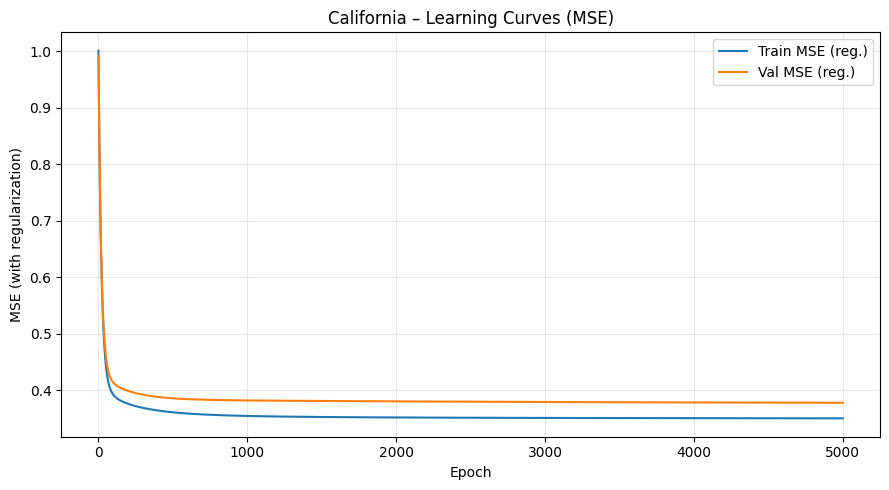

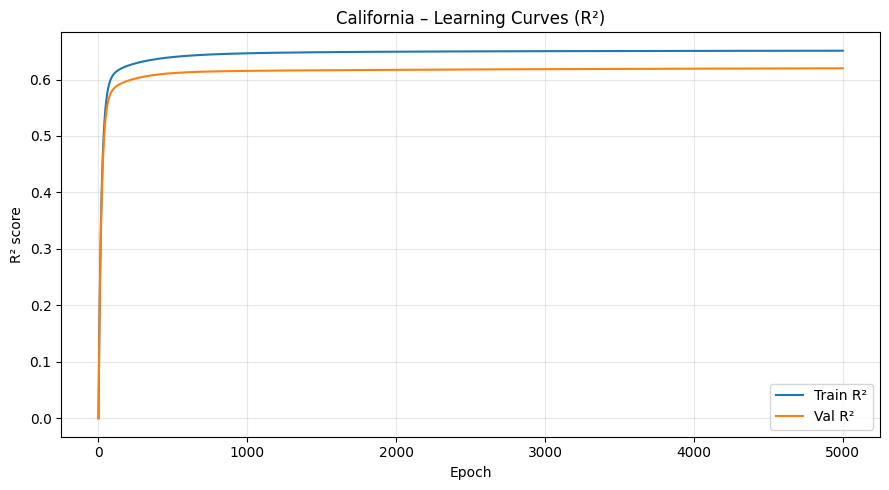

In [36]:
epochs_seen = np.arange(1, len(model_reg.train_mse) + 1)

# 1) MSE
plt.figure(figsize=(9, 5))
plt.plot(epochs_seen, model_reg.train_mse, label="Train MSE (reg.)")
if len(model_reg.val_mse) > 0:
    plt.plot(epochs_seen[:len(model_reg.val_mse)], model_reg.val_mse, label="Val MSE (reg.)")
plt.xlabel("Epoch")
plt.ylabel("MSE (with regularization)")
plt.title("California – Learning Curves (MSE)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 2) R²
plt.figure(figsize=(9, 5))
plt.plot(epochs_seen, model_reg.train_r2, label="Train R²")
if len(model_reg.val_r2) > 0:
    plt.plot(epochs_seen[:len(model_reg.val_r2)], model_reg.val_r2, label="Val R²")
plt.xlabel("Epoch")
plt.ylabel("R² score")
plt.title("California – Learning Curves (R²)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Lab 1 - Titanic


## Model LogisticRegressionTorch


In [38]:
class LogisticRegressionTorch:
    def __init__(
        self,
        device: str = None,
        reg_type: str = "none",   # "none", "l1", "l2", "elasticnet"
        lambda_: float = 0.0,
        l1_ratio: float = 0.5
    ):
        """
        Binary logistic regression with optional L1/L2/ElasticNet regularization.
        """
        self.weights: Tensor = None

        self.reg_type = reg_type
        self.lambda_ = lambda_
        self.l1_ratio = l1_ratio

        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []

        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = device

    def sigmoid(self, z: Tensor) -> Tensor:
        return 1.0 / (1.0 + torch.exp(-z))

    def compute_loss_and_acc(self, y_true: Tensor, y_prob: Tensor):
        """
        Binary cross-entropy loss + accuracy.
        """
        eps = 1e-8
        loss = -torch.mean(
            y_true * torch.log(y_prob + eps) +
            (1.0 - y_true) * torch.log(1.0 - y_prob + eps)
        )
        y_pred_label = (y_prob >= 0.5).float()
        acc = (y_pred_label == y_true).float().mean()
        return loss, acc

    def regularization_term(self) -> Tensor:
        if self.lambda_ == 0.0 or self.reg_type == "none":
            return torch.tensor(0.0, device=self.device)

        w_no_bias = self.weights[1:]

        if self.reg_type == "l2":
            return self.lambda_ * torch.sum(w_no_bias ** 2)
        elif self.reg_type == "l1":
            return self.lambda_ * torch.sum(torch.abs(w_no_bias))
        elif self.reg_type == "elasticnet":
            l1 = torch.sum(torch.abs(w_no_bias))
            l2 = torch.sum(w_no_bias ** 2)
            return self.lambda_ * (self.l1_ratio * l1 + (1.0 - self.l1_ratio) * l2)
        else:
            return torch.tensor(0.0, device=self.device)

    def fit(
        self,
        X: Tensor,
        y: Tensor,
        learning_rate: float = 0.01,
        epochs: int = 1000,
        validation_data=None,
        patience: int = 50,
        tol: float = 1e-6,
        verbose: bool = True,
    ):
        X = X.to(self.device)
        y = y.to(self.device)
        n_samples, n_features = X.shape

        self.weights = torch.zeros(n_features, device=self.device)

        Xv, yv = None, None
        if validation_data is not None:
            Xv, yv = validation_data
            Xv = Xv.to(self.device)
            yv = yv.to(self.device)

        best_val = float("inf")
        best_w = self.weights.clone()
        wait = 0

        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []

        for epoch in range(epochs):
            # forward
            logits = X @ self.weights
            y_prob = self.sigmoid(logits)

            loss, acc = self.compute_loss_and_acc(y, y_prob)
            reg = self.regularization_term()
            loss_reg = loss + reg

            self.train_loss.append(loss_reg.item())
            self.train_acc.append(acc.item())

            if Xv is not None and yv is not None:
                logits_val = Xv @ self.weights
                yv_prob = self.sigmoid(logits_val)
                vloss, vacc = self.compute_loss_and_acc(yv, yv_prob)
                reg_val = self.regularization_term()
                vloss_reg = vloss + reg_val

                self.val_loss.append(vloss_reg.item())
                self.val_acc.append(vacc.item())

                if vloss_reg.item() + tol < best_val:
                    best_val = vloss_reg.item()
                    best_w = self.weights.clone()
                    wait = 0
                else:
                    wait += 1
                    if wait >= patience:
                        if verbose:
                            print(
                                f"[Early stop] epoch={epoch}, best val loss={best_val:.6f}"
                            )
                        self.weights = best_w
                        break

            # gradient (data term)
            error = y_prob - y
            grad = (1.0 / n_samples) * (X.t() @ error)

            # gradient (regularization)
            if self.lambda_ != 0.0 and self.reg_type != "none":
                w_no_bias = self.weights[1:]
                if self.reg_type == "l2":
                    grad_reg_rest = 2.0 * self.lambda_ * w_no_bias
                elif self.reg_type == "l1":
                    grad_reg_rest = self.lambda_ * torch.sign(w_no_bias)
                elif self.reg_type == "elasticnet":
                    grad_reg_rest = self.lambda_ * (
                        self.l1_ratio * torch.sign(w_no_bias)
                        + 2.0 * (1.0 - self.l1_ratio) * w_no_bias
                    )
                else:
                    grad_reg_rest = torch.zeros_like(w_no_bias)

                grad[1:] += grad_reg_rest

            # update
            self.weights = self.weights - learning_rate * grad

            if verbose and epoch % 100 == 0:
                msg = (
                    f"Epoch {epoch:4d} | "
                    f"train loss={loss.item():.4f}, acc={acc.item():.4f}"
                )
                if Xv is not None and yv is not None:
                    msg += (
                        f" | val loss={vloss.item():.4f}, val acc={vacc.item():.4f}"
                    )
                print(msg)

    def predict_proba(self, X: Tensor) -> Tensor:
        X = X.to(self.device)
        with torch.no_grad():
            logits = X @ self.weights
            y_prob = self.sigmoid(logits)
        return y_prob.detach().cpu()

    def predict(self, X: Tensor) -> Tensor:
        y_prob = self.predict_proba(X)
        return (y_prob >= 0.5).float()


## Preprocessing dataset Titanic

In [39]:
titanic_path = "/content/Titanic-Dataset.csv"
df_tit = pd.read_csv(titanic_path)

print("Shape:", df_tit.shape)
print(df_tit.head())

# Target
y_np_cls = df_tit["Survived"].values.astype(np.float32)

# Chọn feature đơn giản
features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
X_df = df_tit[features].copy()

# Missing
X_df["Age"] = X_df["Age"].fillna(X_df["Age"].median())
X_df["Fare"] = X_df["Fare"].fillna(X_df["Fare"].median())
X_df["Embarked"] = X_df["Embarked"].fillna(X_df["Embarked"].mode()[0])

# Encode Sex: female=1, male=0
X_df["Sex"] = (X_df["Sex"] == "female").astype(np.float32)

# One-hot Embarked
embarked_dummies = pd.get_dummies(X_df["Embarked"], prefix="Embarked")
X_df = pd.concat([X_df.drop(columns=["Embarked"]), embarked_dummies], axis=1)

print("Features after encoding:\n", X_df.head())
X_np_cls = X_df.values.astype(np.float32)


Shape: (891, 12)
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   

Split train/test, scale X, add bias

In [40]:
X_train_np_cls, X_test_np_cls, y_train_np_cls, y_test_np_cls = train_test_split_np(
    X_np_cls, y_np_cls, test_size=0.2, random_state=42
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

X_train_t_cls = torch.from_numpy(X_train_np_cls).to(device)
X_test_t_cls  = torch.from_numpy(X_test_np_cls).to(device)
y_train_t_cls = torch.from_numpy(y_train_np_cls).to(device)
y_test_t_cls  = torch.from_numpy(y_test_np_cls).to(device)

# Scale X (y là 0/1 không cần scale)
scaler_X_cls = StandardScalerTorch()
X_train_s_cls = scaler_X_cls.fit_transform(X_train_t_cls)
X_test_s_cls  = scaler_X_cls.transform(X_test_t_cls)

X_train_b_cls = add_bias_torch(X_train_s_cls)
X_test_b_cls  = add_bias_torch(X_test_s_cls)

X_tr_cls, X_val_cls, y_tr_cls, y_val_cls = train_val_split_torch(
    X_train_b_cls, y_train_t_cls, val_size=0.1, random_state=42
)

Using device: cpu


## Train model LogisticRegressionTorch

In [41]:
model_log = LogisticRegressionTorch(
    device=device,
    reg_type="none",
    lambda_=0.0
)

model_log.fit(
    X_tr_cls, y_tr_cls,
    learning_rate=0.05,
    epochs=2000,
    validation_data=(X_val_cls, y_val_cls),
    patience=200,
    tol=1e-6,
    verbose=True
)

Epoch    0 | train loss=0.6931, acc=0.3598 | val loss=0.6931, val acc=0.4507
Epoch  100 | train loss=0.4699, acc=0.8022 | val loss=0.5630, val acc=0.7465
Epoch  200 | train loss=0.4411, acc=0.8022 | val loss=0.5639, val acc=0.7465
Epoch  300 | train loss=0.4328, acc=0.8053 | val loss=0.5706, val acc=0.7465
[Early stop] epoch=334, best val loss=0.561309


In [42]:

y_train_pred_cls = model_log.predict(X_train_b_cls).numpy()
y_test_pred_cls  = model_log.predict(X_test_b_cls).numpy()

train_acc = accuracy_score(y_train_np_cls, y_train_pred_cls)
test_acc  = accuracy_score(y_test_np_cls,  y_test_pred_cls)

train_f1 = f1_score(y_train_np_cls, y_train_pred_cls)
test_f1  = f1_score(y_test_np_cls,  y_test_pred_cls)

print("\n=== Titanic Logistic Regression (no regularization) ===")
print(f"Train accuracy = {train_acc:.4f}, F1 = {train_f1:.4f}")
print(f"Test  accuracy = {test_acc:.4f}, F1 = {test_f1:.4f}")



=== Titanic Logistic Regression (no regularization) ===
Train accuracy = 0.7966, F1 = 0.7206
Test  accuracy = 0.7921, F1 = 0.7550


## Draw graphics

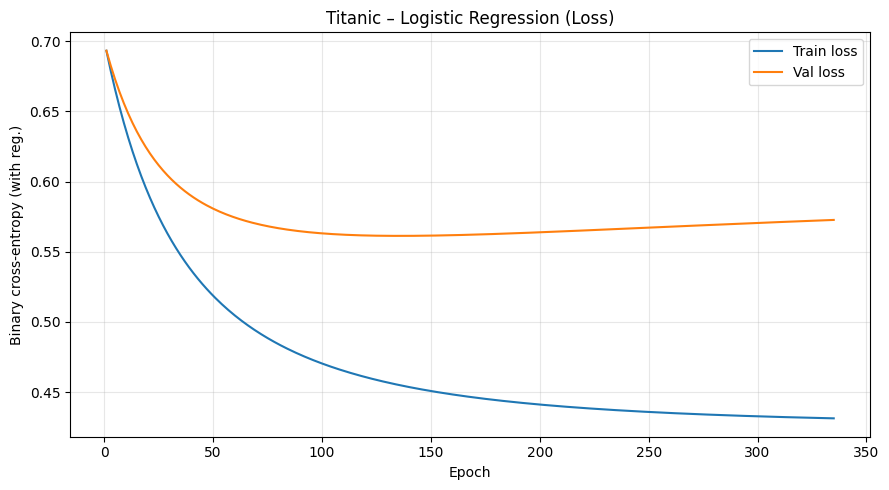

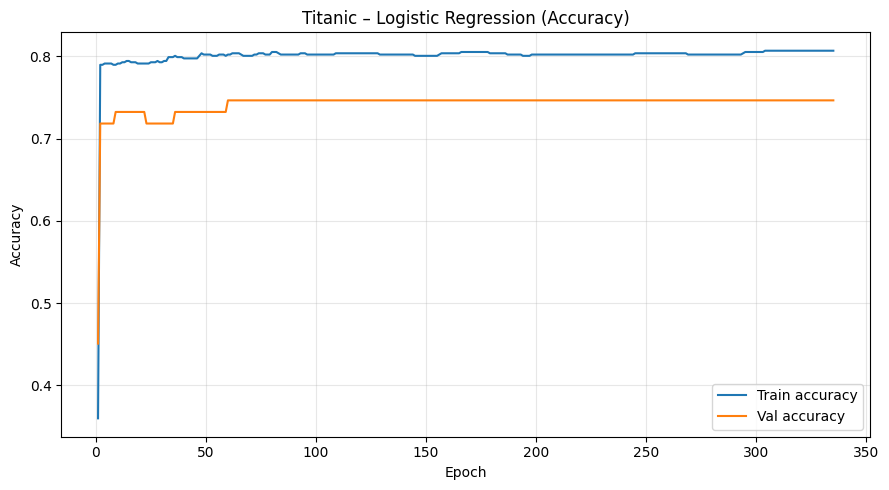

In [43]:
epochs_seen = np.arange(1, len(model_log.train_loss) + 1)

# 1) Loss
plt.figure(figsize=(9, 5))
plt.plot(epochs_seen, model_log.train_loss, label="Train loss")
if len(model_log.val_loss) > 0:
    plt.plot(epochs_seen[:len(model_log.val_loss)], model_log.val_loss, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Binary cross-entropy (with reg.)")
plt.title("Titanic – Logistic Regression (Loss)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 2) Accuracy
plt.figure(figsize=(9, 5))
plt.plot(epochs_seen, model_log.train_acc, label="Train accuracy")
if len(model_log.val_acc) > 0:
    plt.plot(epochs_seen[:len(model_log.val_acc)], model_log.val_acc, label="Val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Titanic – Logistic Regression (Accuracy)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# Lab 2

## Model KNNClassifierTorch

In [2]:
class KNNClassifierTorch:
    def __init__(
        self,
        k: int = 3,
        metric: str = "euclidean",   # 'euclidean', 'manhattan', 'minkowski', 'cosine'
        p: int = 2,                  # for Minkowski
        device: str = None,
        test_batch_size: int = 256,  # batch size over test set
        train_chunk_size: int = None # chunk size over train set (for heavy metrics)
    ):
        """
        Optimized KNN classifier using raw PyTorch tensors.

        - Euclidean / Cosine: use 2D matrix formulas (no (B,N,D) tensor).
        - Manhattan / Minkowski: can use train_chunk_size to avoid memory explosion.

        Parameters
        ----------
        k : int
            Number of nearest neighbors.
        metric : str
            Distance metric: 'euclidean', 'manhattan', 'minkowski', 'cosine'.
        p : int
            Parameter p for Minkowski distance.
        device : str
            'cpu' or 'cuda'. If None, auto-detect.
        test_batch_size : int
            Batch size for iterating over X_test.
        train_chunk_size : int or None
            If not None, iterate train set in chunks of this size
            to reduce memory footprint (useful for Manhattan/Minkowski).
        """
        self.k = k
        self.metric = metric
        self.p = p
        self.test_batch_size = test_batch_size
        self.train_chunk_size = train_chunk_size

        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = device

        self.X_train: Tensor = None
        self.y_train: Tensor = None
        self.X_train_norm: Tensor = None  # for cosine
        self.N_train: int = 0
        self.D: int = 0

    # --------------------- FIT ---------------------
    def fit(self, X_train: np.ndarray, y_train: np.ndarray):
        """
        Store training data as torch tensors and precompute norms if needed.
        """
        X_train = X_train.astype("float32")
        y_train = y_train.astype("int64")

        self.X_train = torch.from_numpy(X_train).to(self.device)  # (N, D)
        self.y_train = torch.from_numpy(y_train).to(self.device)  # (N,)
        self.N_train, self.D = self.X_train.shape

        # Precompute norms for cosine metric
        if self.metric == "cosine":
            self.X_train_norm = torch.sqrt(
                (self.X_train ** 2).sum(dim=1) + 1e-12
            )  # (N,)

    # -------- Euclidean / Cosine: full distance for one test batch --------
    def _pairwise_distance_full(self, X_batch: Tensor) -> Tensor:
        """
        Compute pairwise distance between X_batch (B,D) and full X_train (N,D)
        in a memory-friendly way using only 2D matrices
        for Euclidean and Cosine metrics.
        Returns (B, N).
        """
        if self.metric == "euclidean":
            # ||x||^2: (B,1)
            x_sq = (X_batch ** 2).sum(dim=1, keepdim=True)
            # ||y||^2: (1,N)
            y_sq = (self.X_train ** 2).sum(dim=1).unsqueeze(0)
            # x y^T: (B,N)
            cross = X_batch @ self.X_train.t()
            dist_sq = x_sq + y_sq - 2.0 * cross
            dist_sq = torch.clamp(dist_sq, min=0.0)
            # can keep squared distance, because top-k is monotonic
            return dist_sq

        elif self.metric == "cosine":
            # x_norm: (B,)
            x_norm = torch.sqrt((X_batch ** 2).sum(dim=1) + 1e-12)
            # denom: (B,N)
            denom = x_norm.unsqueeze(1) * self.X_train_norm.unsqueeze(0)
            dot = X_batch @ self.X_train.t()  # (B,N)
            cos_sim = dot / denom
            cos_dist = 1.0 - cos_sim
            return cos_dist

        else:
            raise ValueError("Full matrix formula is only for euclidean/cosine.")

    # -------- Manhattan / Minkowski (and optional chunking) --------
    def _pairwise_distance_chunk(
        self, X_batch: Tensor, X_train_chunk: Tensor
    ) -> Tensor:
        """
        Compute pairwise distance between X_batch (B,D) and X_train_chunk (Nc,D)
        for Manhattan or Minkowski. Uses explicit (B,Nc,D) tensor,
        but Nc is small when using train_chunk_size.
        Returns (B, Nc).
        """
        x = X_batch.unsqueeze(1)          # (B,1,D)
        y = X_train_chunk.unsqueeze(0)    # (1,Nc,D)
        diff = x - y                      # (B,Nc,D)

        if self.metric == "manhattan":
            dist = diff.abs().sum(dim=2)  # (B,Nc)
            return dist
        elif self.metric == "minkowski":
            p = self.p
            dist_p = (diff.abs() ** p).sum(dim=2)
            dist = dist_p ** (1.0 / p)
            return dist
        else:
            raise ValueError("Chunked distance is intended for manhattan/minkowski.")

    # ------------------- PREDICT -------------------
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """
        Predict labels for X_test (numpy array).
        Process X_test in batches (test_batch_size) and optionally
        X_train in chunks (train_chunk_size) to avoid RAM explosion.
        """
        X_test = X_test.astype("float32")
        X_test_t = torch.from_numpy(X_test).to(self.device)
        N_test = X_test_t.shape[0]

        all_preds = []

        # iterate over test set in batches
        for start in range(0, N_test, self.test_batch_size):
            end = min(start + self.test_batch_size, N_test)
            X_batch = X_test_t[start:end]  # (B,D)
            B = X_batch.shape[0]

            # --- Case 1: Euclidean/Cosine and we can load full train at once ---
            if self.metric in ["euclidean", "cosine"] and self.train_chunk_size is None:
                dist = self._pairwise_distance_full(X_batch)  # (B,N_train)
                # top-k smallest distances
                _, indices = torch.topk(dist, k=self.k, dim=1, largest=False)
                neighbor_labels = self.y_train[indices]  # (B,k)

            else:
                # --- Case 2: use train-chunking (especially for Manhattan/Minkowski) ---
                if self.train_chunk_size is None:
                    # If user did not specify, choose a default chunk size
                    # that should be safe in typical Colab.
                    train_chunk_size = 2000
                else:
                    train_chunk_size = self.train_chunk_size

                # maintain global top-k for each row in batch
                # init distances with +inf and indices = -1
                dist_k = torch.full(
                    (B, self.k),
                    float("inf"),
                    device=self.device,
                )
                idx_k = torch.full(
                    (B, self.k),
                    -1,
                    dtype=torch.long,
                    device=self.device,
                )

                # iterate over training set in chunks
                for t_start in range(0, self.N_train, train_chunk_size):
                    t_end = min(t_start + train_chunk_size, self.N_train)
                    X_train_chunk = self.X_train[t_start:t_end]  # (Nc,D)
                    Nc = X_train_chunk.shape[0]

                    if self.metric in ["manhattan", "minkowski"]:
                        dist_chunk = self._pairwise_distance_chunk(
                            X_batch, X_train_chunk
                        )  # (B,Nc)
                    elif self.metric == "euclidean":
                        # Euclidean but chunked over train:
                        x_sq = (X_batch ** 2).sum(dim=1, keepdim=True)      # (B,1)
                        y_sq = (X_train_chunk ** 2).sum(dim=1).unsqueeze(0) # (1,Nc)
                        cross = X_batch @ X_train_chunk.t()                 # (B,Nc)
                        dist_sq = x_sq + y_sq - 2.0 * cross
                        dist_chunk = torch.clamp(dist_sq, min=0.0)          # (B,Nc)
                    elif self.metric == "cosine":
                        # Cosine but chunked over train:
                        x_norm = torch.sqrt((X_batch ** 2).sum(dim=1) + 1e-12)  # (B,)
                        y_norm = torch.sqrt(
                            (X_train_chunk ** 2).sum(dim=1) + 1e-12
                        )                                                       # (Nc,)
                        denom = x_norm.unsqueeze(1) * y_norm.unsqueeze(0)       # (B,Nc)
                        dot = X_batch @ X_train_chunk.t()                       # (B,Nc)
                        cos_sim = dot / denom
                        dist_chunk = 1.0 - cos_sim                              # (B,Nc)
                    else:
                        raise ValueError(f"Unsupported metric: {self.metric}")

                    # current indices of this chunk (global indices in train)
                    idx_chunk = torch.arange(
                        t_start, t_end, device=self.device
                    ).unsqueeze(0).expand(B, -1)  # (B,Nc)

                    # concat old top-k with new chunk distances
                    dist_cat = torch.cat([dist_k, dist_chunk], dim=1)  # (B,k+Nc)
                    idx_cat = torch.cat([idx_k, idx_chunk], dim=1)      # (B,k+Nc)

                    # take new top-k
                    dist_k, top_idx = torch.topk(
                        dist_cat, k=self.k, dim=1, largest=False
                    )  # (B,k)
                    # gather corresponding indices
                    idx_k = idx_cat.gather(1, top_idx)

                # after all chunks, idx_k contains global indices of k nearest
                neighbor_labels = self.y_train[idx_k]  # (B,k)

            # majority vote for each row in batch
            for labels_row in neighbor_labels:
                counts = torch.bincount(labels_row)
                pred_label = torch.argmax(counts).item()
                all_preds.append(pred_label)

        return np.array(all_preds, dtype=np.int64)


## Lab 2 - Fashion-MNIST dataset

Data loaded successfully!
Full train shape: (46344, 785)
Full test  shape: (10000, 785)
Subsampled train shape: (5000, 784)
Subsampled test  shape: (1000, 784)

==== KNN (PyTorch) metric: euclidean ====
Accuracy:  0.8150
Precision: 0.8218
Recall:    0.8150
F1-score:  0.8150


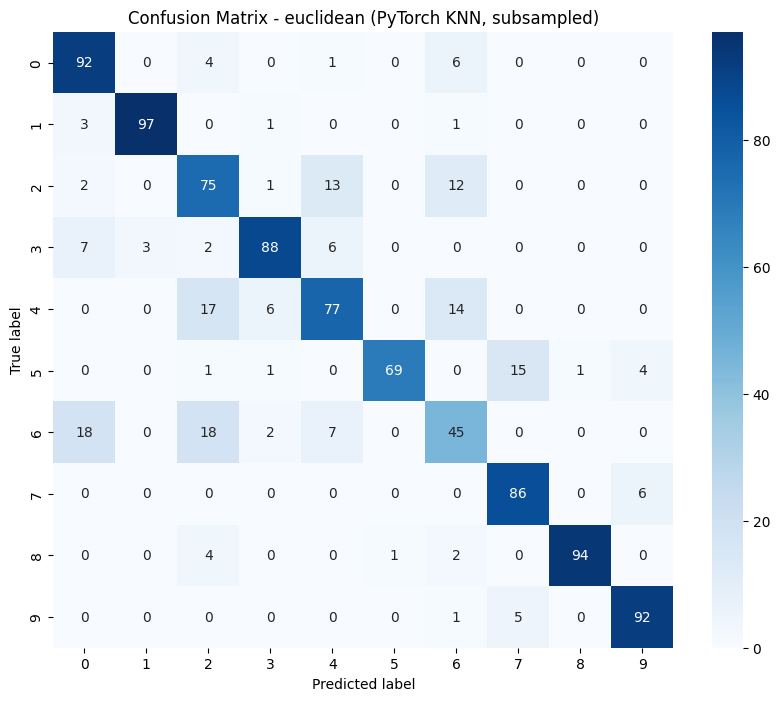


==== KNN (PyTorch) metric: manhattan ====
Accuracy:  0.8200
Precision: 0.8235
Recall:    0.8200
F1-score:  0.8196


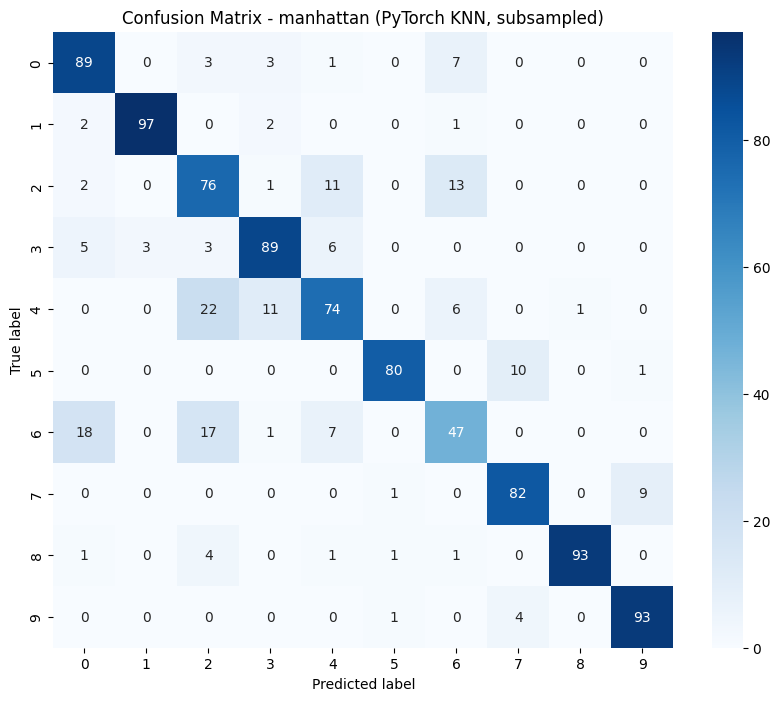


==== KNN (PyTorch) metric: minkowski ====
Accuracy:  0.7960
Precision: 0.8086
Recall:    0.7960
F1-score:  0.7972


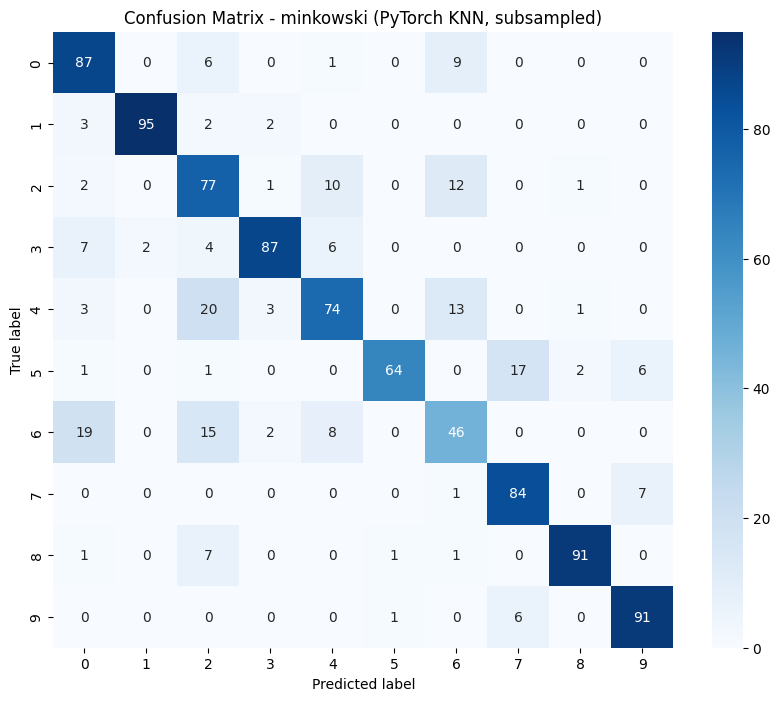


==== KNN (PyTorch) metric: cosine ====
Accuracy:  0.8150
Precision: 0.8212
Recall:    0.8150
F1-score:  0.8123


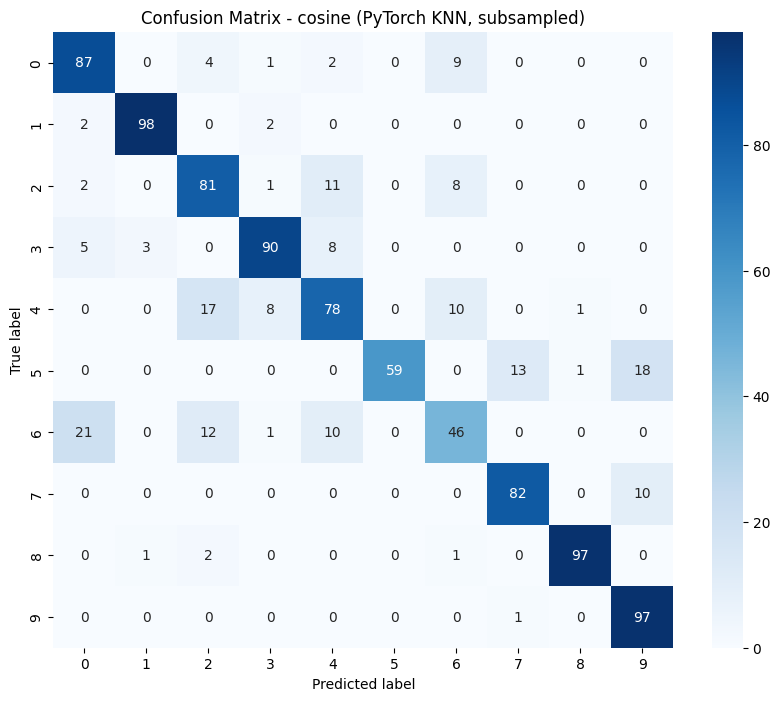

In [4]:
# 1. Đọc dữ liệu
train_data = pd.read_csv('/content/fashion-mnist_train.csv')
test_data  = pd.read_csv('/content/fashion-mnist_test.csv')
print("Data loaded successfully!")
print("Full train shape:", train_data.shape)
print("Full test  shape:", test_data.shape)

# 2. Chuẩn hóa
X_train = train_data.drop(columns=['label']).values.astype('float32') / 255.0
y_train = train_data['label'].values.astype('int64')
X_test  = test_data.drop(columns=['label']).values.astype('float32') / 255.0
y_test  = test_data['label'].values.astype('int64')

# Thay NaN bằng 0
X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
X_test  = np.nan_to_num(X_test,  nan=0.0, posinf=0.0, neginf=0.0)

# 3. Lấy một phần dữ liệu để tránh nổ RAM khi dùng KNN "tự code"
n_train_max = 5000   # có thể chỉnh 5000 / 15000 tùy tài nguyên
n_test_max  = 1000   # đủ để đánh giá

rng = np.random.default_rng(42)
train_idx = rng.choice(X_train.shape[0], size=n_train_max, replace=False)
test_idx  = rng.choice(X_test.shape[0],  size=n_test_max,  replace=False)

X_train_sub = X_train[train_idx]
y_train_sub = y_train[train_idx]
X_test_sub  = X_test[test_idx]
y_test_sub  = y_test[test_idx]

print("Subsampled train shape:", X_train_sub.shape)
print("Subsampled test  shape:", X_test_sub.shape)

# 4. Chạy KNN Torch với 4 loại distance
metrics = ['euclidean', 'manhattan', 'minkowski', 'cosine']

for metric in metrics:
    print(f"\n==== KNN (PyTorch) metric: {metric} ====")

    if metric == 'minkowski':
        knn = KNNClassifierTorch(
            k=3,
            metric=metric,
            p=3,
            test_batch_size=256,     # batch trên TẬP TEST
            train_chunk_size=2000    # an toàn hơn cho Minkowski
        )
    elif metric == 'manhattan':
        knn = KNNClassifierTorch(
            k=3,
            metric=metric,
            test_batch_size=256,
            train_chunk_size=2000
        )
    else:
        # euclidean / cosine: có thể để train_chunk_size=None hoặc 2000 đều được
        knn = KNNClassifierTorch(
            k=3,
            metric=metric,
            test_batch_size=256,
            train_chunk_size=None
        )

    # Huấn luyện trên subset
    knn.fit(X_train_sub, y_train_sub)

    # Dự đoán trên subset test
    y_pred = knn.predict(X_test_sub)
    y_test_eval = y_test_sub

    acc = accuracy_score(y_test_eval, y_pred)
    precision = precision_score(y_test_eval, y_pred, average='weighted')
    recall = recall_score(y_test_eval, y_pred, average='weighted')
    f1 = f1_score(y_test_eval, y_pred, average='weighted')

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_test_eval, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix - {metric} (PyTorch KNN, subsampled)')
    plt.show()


## Model KNNRegressionTorch


In [4]:
class KNNRegressorTorch:
    def __init__(self, k=3, metric='euclidean', p=2, device=None, batch_size=512):
        """
        KNN regressor implemented with raw PyTorch tensors.

        :param k: number of nearest neighbors
        :param metric: 'euclidean', 'manhattan', 'minkowski', 'cosine'
        :param p: Minkowski parameter
        :param device: 'cpu' or 'cuda'
        :param batch_size: batch size for test data
        """
        self.k = k
        self.metric = metric
        self.p = p
        self.batch_size = batch_size

        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = device

        self.X_train = None  # (N_train, D)
        self.y_train = None  # (N_train,)

    def fit(self, X_train: np.ndarray, y_train: np.ndarray):
        """
        Store training data as torch tensors.
        """
        self.X_train = torch.from_numpy(X_train.astype('float32')).to(self.device)
        self.y_train = torch.from_numpy(y_train.astype('float32')).to(self.device)

    def _pairwise_distance(self, X_batch: Tensor) -> Tensor:
        """
        Same distance computation as in KNNClassifierTorch.
        """
        B, D = X_batch.shape
        N, _ = self.X_train.shape

        x = X_batch.unsqueeze(1)          # (B, 1, D)
        x_train = self.X_train.unsqueeze(0)  # (1, N, D)
        diff = x - x_train                # (B, N, D)

        if self.metric == 'euclidean':
            dist_sq = (diff ** 2).sum(dim=2)  # (B, N)
            return dist_sq

        elif self.metric == 'manhattan':
            dist = diff.abs().sum(dim=2)      # (B, N)
            return dist

        elif self.metric == 'minkowski':
            p = self.p
            dist_p = (diff.abs() ** p).sum(dim=2)
            dist = dist_p ** (1.0 / p)
            return dist

        elif self.metric == 'cosine':
            x_norm = torch.sqrt((x ** 2).sum(dim=2) + 1e-12)        # (B, 1)
            y_norm = torch.sqrt((x_train ** 2).sum(dim=2) + 1e-12)  # (1, N)
            dot = (x * x_train).sum(dim=2)                          # (B, N)
            cos_sim = dot / (x_norm * y_norm)
            cos_dist = 1.0 - cos_sim
            return cos_dist

        else:
            raise ValueError(f"Unsupported metric: {self.metric}")

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """
        Predict regression target for X_test.
        Returns numpy array (N_test,)
        """
        X_test_t = torch.from_numpy(X_test.astype('float32')).to(self.device)
        N_test = X_test_t.shape[0]

        preds = []

        for start in range(0, N_test, self.batch_size):
            end = min(start + self.batch_size, N_test)
            X_batch = X_test_t[start:end]

            dist = self._pairwise_distance(X_batch)  # (B, N_train)

            _, indices = torch.topk(dist, k=self.k, dim=1, largest=False)

            neighbor_vals = self.y_train[indices]  # (B, k)

            # average
            y_pred_batch = neighbor_vals.mean(dim=1)  # (B,)
            preds.append(y_pred_batch.detach().cpu().numpy())

        preds = np.concatenate(preds, axis=0)
        return preds


## Lab 2 - Insurance dataset

In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_error,
    median_absolute_error, explained_variance_score
)

# 1. Load dataset
data = pd.read_csv("/content/insurance.csv")
features = ['age', 'sex', 'bmi', 'children', 'smoker', 'region']
target = 'charges'

X = data[features].copy()
y = data[target].values.astype('float32')

# Encode categorical
X['sex'] = X['sex'].map({'male': 0, 'female': 1}).astype('float32')
X['smoker'] = X['smoker'].map({'no': 0, 'yes': 1}).astype('float32')
X = pd.get_dummies(X, columns=['region'], drop_first=True)

# Chuẩn hóa numeric
numeric_cols = ['age', 'bmi', 'children']
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

X_values = X.values.astype('float32')

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_values, y, test_size=0.2, random_state=42
)

metrics = [
    ('euclidean', None),
    ('manhattan', None),
    ('minkowski', 3),  # p=3
    ('cosine', None)
]

for metric, p_val in metrics:
    print(f"\n=== Metric: {metric} (PyTorch KNN) ===")
    knn = KNNRegressorTorch(
        k=5,
        metric=metric,
        p=p_val if p_val is not None else 2,
        batch_size=512
    )
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    median_ae = median_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    evs = explained_variance_score(y_test, y_pred)

    print(f"MSE:  {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE:  {mae:.2f}")
    print(f"Median AE: {median_ae:.2f}")
    print(f"R^2:  {r2:.4f}")
    print(f"Explained Variance Score: {evs:.4f}")

    # Khảo sát MSE theo k
    print("\nMSE with k (1–15):")
    for k_val in range(1, 16):
        knn_k = KNNRegressorTorch(
            k=k_val,
            metric=metric,
            p=p_val if p_val is not None else 2,
            batch_size=512
        )
        knn_k.fit(X_train, y_train)
        y_pred_k = knn_k.predict(X_test)
        mse_k = mean_squared_error(y_test, y_pred_k)
        print(f"k={k_val}: MSE={mse_k:.2f}")



=== Metric: euclidean (PyTorch KNN) ===
MSE:  46530212.00
RMSE: 6821.31
MAE:  3905.20
Median AE: 2083.35
R^2:  0.7003
Explained Variance Score: 0.7070

MSE with k (1–15):
k=1: MSE=55568712.00
k=2: MSE=48553504.00
k=3: MSE=43879128.00
k=4: MSE=42405968.00
k=5: MSE=46530212.00
k=6: MSE=48001248.00
k=7: MSE=48791248.00
k=8: MSE=49511952.00
k=9: MSE=52046412.00
k=10: MSE=52317476.00
k=11: MSE=53508480.00
k=12: MSE=56104752.00
k=13: MSE=57873876.00
k=14: MSE=58542660.00
k=15: MSE=57976732.00

=== Metric: manhattan (PyTorch KNN) ===
MSE:  39564532.00
RMSE: 6290.03
MAE:  3802.02
Median AE: 2177.21
R^2:  0.7452
Explained Variance Score: 0.7504

MSE with k (1–15):
k=1: MSE=58456200.00
k=2: MSE=49550892.00
k=3: MSE=41110404.00
k=4: MSE=37520836.00
k=5: MSE=39564532.00
k=6: MSE=41310056.00
k=7: MSE=42310336.00
k=8: MSE=42778632.00
k=9: MSE=45729368.00
k=10: MSE=46477260.00
k=11: MSE=47883052.00
k=12: MSE=48406472.00
k=13: MSE=48040860.00
k=14: MSE=48387944.00
k=15: MSE=48796496.00

=== Metric: m